### Practice Notebook
* Creating data as well as a multi-class classification model to get the correct predictions using the techniques learned previously

In [7]:
import torch
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

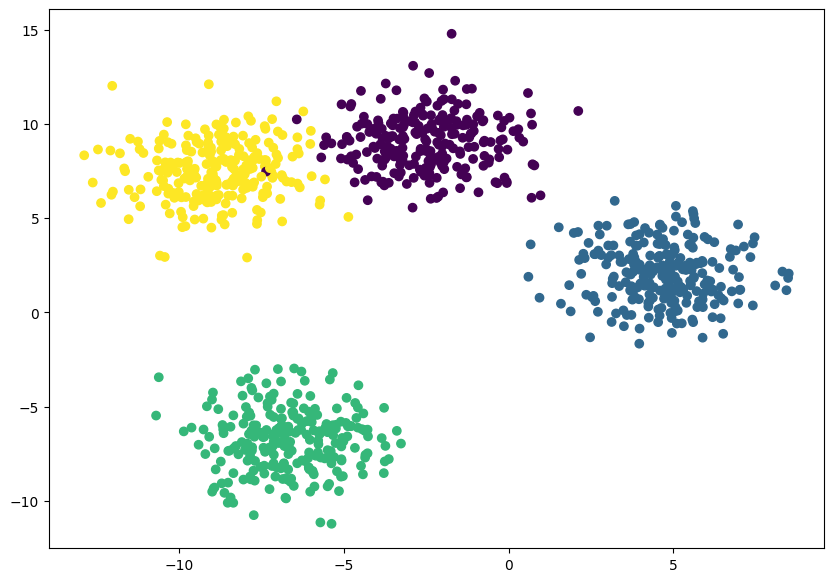

In [3]:
# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X, Y = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
Y = torch.from_numpy(Y).type(torch.LongTensor)

# 3. Split into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=RANDOM_SEED)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], c=Y)

In [6]:
# setting the device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [48]:
# Model Building
class MultiClassClassification(nn.Module):
    def __init__(self, input_features, n_classes):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=n_classes),
        )

    def forward(self, x):
        return self.layer_stack(x)

In [49]:
model = MultiClassClassification(NUM_FEATURES, NUM_CLASSES).to(device)
model

MultiClassClassification(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=4, bias=True)
  )
)

In [50]:
from torchsummary import summary
summary(model, (1, 2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 16]              48
              ReLU-2                [-1, 1, 16]               0
            Linear-3                [-1, 1, 32]             544
              ReLU-4                [-1, 1, 32]               0
            Linear-5                 [-1, 1, 4]             132
Total params: 724
Trainable params: 724
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [51]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                            lr=0.01)


In [52]:
# create the accuracy function
def accuracy_fn(y_true,  y_pred):
    result = torch.eq(y_true, y_pred).sum().item()
    return (result / len(y_true)) * 100

In [53]:
# create the softmax function
def softmax(z):
    return torch.exp(-z) / (1 + torch.exp(-z))

In [54]:
# Model Training and Evaluation
torch.manual_seed(42)

epochs = 100
X_train, Y_train = X_train.to(device), Y_train.to(device)
X_test, Y_test = X_test.to(device), Y_test.to(device)

for i in range(epochs):
    model.train()
    y_probs = softmax(model(X_train))
    y_preds = torch.argmax(y_probs, dim=1)
    train_loss = loss_fn(y_probs, Y_train)
    train_acc = accuracy_fn(Y_train, y_preds)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    model.eval()
    with torch.inference_mode():
        test_probs = softmax(model(X_test))
        test_preds = torch.argmax(test_probs, dim=1)
        test_loss = loss_fn(test_probs, Y_test)
        test_acc = accuracy_fn(Y_test, test_preds)

        if i % 10 == 0:
            print(f"Epoch: {i} | Loss: {train_loss:.5f}, Acc: {train_acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 1.41690, Acc: 39.75% | Test Loss: 1.33591, Test Acc: 51.00%
Epoch: 10 | Loss: 0.86908, Acc: 98.62% | Test Loss: 0.84408, Test Acc: 99.50%
Epoch: 20 | Loss: 0.76686, Acc: 99.12% | Test Loss: 0.76122, Test Acc: 99.50%
Epoch: 30 | Loss: 0.75574, Acc: 99.12% | Test Loss: 0.75250, Test Acc: 99.50%
Epoch: 40 | Loss: 0.75351, Acc: 99.12% | Test Loss: 0.75033, Test Acc: 99.50%
Epoch: 50 | Loss: 0.75256, Acc: 99.25% | Test Loss: 0.74902, Test Acc: 99.50%
Epoch: 60 | Loss: 0.75207, Acc: 99.25% | Test Loss: 0.74851, Test Acc: 99.50%
Epoch: 70 | Loss: 0.75173, Acc: 99.25% | Test Loss: 0.74822, Test Acc: 99.50%
Epoch: 80 | Loss: 0.75146, Acc: 99.25% | Test Loss: 0.74795, Test Acc: 99.50%
Epoch: 90 | Loss: 0.75123, Acc: 99.38% | Test Loss: 0.74770, Test Acc: 99.50%


In [55]:
# Lets see the model predictions
model.eval()
with torch.inference_mode():
    y_preds = torch.argmax(softmax(model(X_test[:10])), dim=1)
y_preds, Y_test[:10]

(tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0'),
 tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0'))

In [56]:
def plot_decision_boundary(model, X, y, resolution=0.01, device='cpu'):
    """
    Plots the decision boundary of a PyTorch classification model.

    Args:
        model: PyTorch model to evaluate.
        X (torch.Tensor): Input data (features), should be 2D with shape (n_samples, 2).
        y (torch.Tensor): True labels (n_samples,).
        resolution (float): Grid resolution for plotting.
        device (str): Device ('cpu' or 'cuda') where the model is located.
    """
    # Ensure the model is in evaluation mode
    model.eval()

    # Move data and model to the specified device
    X = X.to(device)
    y = y.to(device)
    model.to(device)

    # Define the grid for plotting
    x_min, x_max = X[:, 0].min().item() - 0.5, X[:, 0].max().item() + 0.5
    y_min, y_max = X[:, 1].min().item() - 0.5, X[:, 1].max().item() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))

    # Prepare grid points as input to the model
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32).to(device)

    # Predict probabilities for the grid points
    with torch.no_grad():
        predictions = model(grid)
        if predictions.shape[1] > 1:  # Multi-class classification
            Z = torch.argmax(softmax(predictions), axis=1).cpu().numpy()
        else:  # Binary classification (single output)
            Z = (torch.sigmoid(predictions).cpu().numpy() > 0.5).astype(int).ravel()

    # Reshape predictions back to the grid shape
    Z = Z.reshape(xx.shape)
    # Plot the decision boundary
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0].cpu(), X[:, 1].cpu(), c=y.cpu(), edgecolor='k')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundary')
    plt.show()

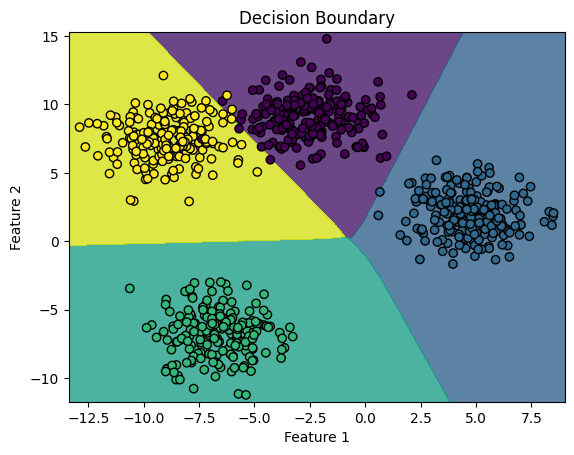

In [57]:
plot_decision_boundary(model, X_train, Y_train, device=device)

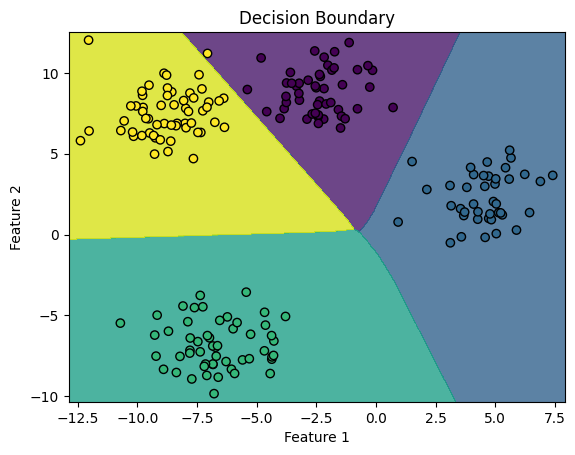

In [58]:
plot_decision_boundary(model, X_test, Y_test, device=device)

In [ ]:
## Note : Remove non-linearity from the model and check what will happen to the model